In [2]:
import pandas as pds
import wikipediaapi
from tqdm import tqdm
import concurrent.futures

In [4]:
!python -m pip install neptune

ERROR: Could not find a version that satisfies the requirement neptune (from versions: none)
ERROR: No matching distribution found for neptune


In [5]:
import spacy
import pandas as pd
import requests
from spacy import displacy
# import en_core_web_sm

nlp = spacy.load('en_core_web_lg')

from spacy.tokens import Span
from spacy.matcher import Matcher

import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx

%matplotlib inline

In [7]:
data = pd.read_csv('C:/Users/sudar/Desktop/Other/ConferenceIndvPaper/FinalYearProject/Knowledge_Graph_Wikipedia_WebScrapped_COVID19_Data-master/tweets.csv')
data.head()

,ID,Tweet,Labels
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10
1,2,BanMediaHouse whose is responsible for spreadi...,6
2,3,Im waiting for someone to say to me that all t...,3 4
3,4,He is a liar. Proven day night. Time again. Li...,6
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8


In [9]:
data.rename(columns={'Tweet':'text'},inplace=True)

In [10]:
data

,ID,text,Labels
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10
1,2,BanMediaHouse whose is responsible for spreadi...,6
2,3,Im waiting for someone to say to me that all t...,3 4
3,4,He is a liar. Proven day night. Time again. Li...,6
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8
...,...,...,...
4995,4996,Life Insurance? I wonder if policies are payin...,4 5 7
4996,4997,My cousin passed away from the corona virus to...,4 5
4997,4998,I guess Mother Nature really hates us. Yellows...,3 5 9 10
4998,4999,So question for the day that isnt related to c...,9 10


In [11]:
data['text'][10]

'i cannot die before watching a concert live corona virus pls try to understand'

## Segmenting Sentences

In [13]:
# Lets take part of the above extracted article
docu = nlp('''i cannot die before watching a concert live corona virus pls try to understand''')

for tokn in docu:
    print(tokn.text, "---", tokn.dep_)

i --- nsubj
can --- aux
not --- neg
die --- ROOT
before --- prep
watching --- pcomp
a --- det
concert --- npadvmod
live --- amod
corona --- compound
virus --- dobj
pls --- intj
try --- advcl
to --- aux
understand --- xcomp


## Extracting entities

In [14]:
def extract_entities(sents):
    enti_one = ""
    enti_two = ""
    dep_prev_token = ""
    txt_prev_token = "" 
    prefix = ""
    modifier = ""
    for tokn in nlp(sents):
        if tokn.dep_ != "punct":
            if tokn.dep_ == "compound":
                prefix = tokn.text
                if dep_prev_token == "compound":
                    prefix = txt_prev_token + " "+ tokn.text
            if tokn.dep_.endswith("mod") == True:
                modifier = tokn.text
                if dep_prev_token == "compound":
                    modifier = txt_prev_token + " "+ tokn.text
            if tokn.dep_.find("subj") == True:
                enti_one = modifier +" "+ prefix + " "+ tokn.text
                prefix = ""
                modifier = ""
                dep_prev_token = ""
                txt_prev_token = ""
            if tokn.dep_.find("obj") == True:
                enti_two = modifier +" "+ prefix +" "+ tokn.text
            dep_prev_token = tokn.dep_
            txt_prev_token = tokn.text
            
    return [enti_one.strip(), enti_two.strip()]

In [15]:
extract_entities("i cannot die before watching a concert live corona virus pls try to understand")

['i', 'live corona virus']

In [53]:
pairs_of_entities = []

for i in tqdm(data['text']):
    pairs_of_entities.append(extract_entities(i))

100%|██████████| 5000/5000 [00:25<00:00, 195.49it/s]


In [54]:
pairs_of_entities[1:6]

[['whose', 'Fake pandemic Corona situation'],
 ['corona thing', 'me'],
 ['when day truth', ''],
 ['reaches', 'new  deaths'],
 ['Coronavirus impact Govt', 'I T Sections']]

## Relation extraction

In [29]:
def obtain_relation(sent):
    
    doc = nlp(sent)
    
    matcher = Matcher(nlp.vocab)
    
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]
    
    matcher.add("matching_1", [pattern])
    
    matcher = matcher(doc)
    h = len(matcher) - 1
    
    span = doc[matcher[h][1]:matcher[h][2]]
    
    return (span.text)

In [30]:
obtain_relation("i cannot die before watching a concert live corona virus pls try to understand")

'die before'

In [50]:
relations = [obtain_relation(j) for j in tqdm(data['text'])]

100%|██████████| 5000/5000 [00:27<00:00, 178.59it/s]


In [51]:
pd.Series(relations).value_counts()

is             217
COVID19        111
coronavirus     75
gon             63
got             60
              ... 
comment by       1
Selling          1
relenting        1
starts           1
banana           1
Length: 2187, dtype: int64

In [62]:
temp = pd.Series(relations).value_counts().tolist()

In [63]:
type(temp)

list

In [64]:
temp

[217,
 111,
 75,
 63,
 60,
 56,
 50,
 47,
 46,
 42,
 41,
 40,
 38,
 36,
 36,
 35,
 32,
 30,
 28,
 28,
 27,
 23,
 22,
 21,
 21,
 20,
 20,
 19,
 19,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 16,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 

In [65]:
max(temp)

217

In [66]:
min(temp)

1

In [69]:
count = 0
for i in range(len(temp)):
    if(temp[i]<20):
        count+=1

## Building graph

In [55]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [56]:
# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target", 
                          edge_attr=True, create_using=ntx.MultiDiGraph())

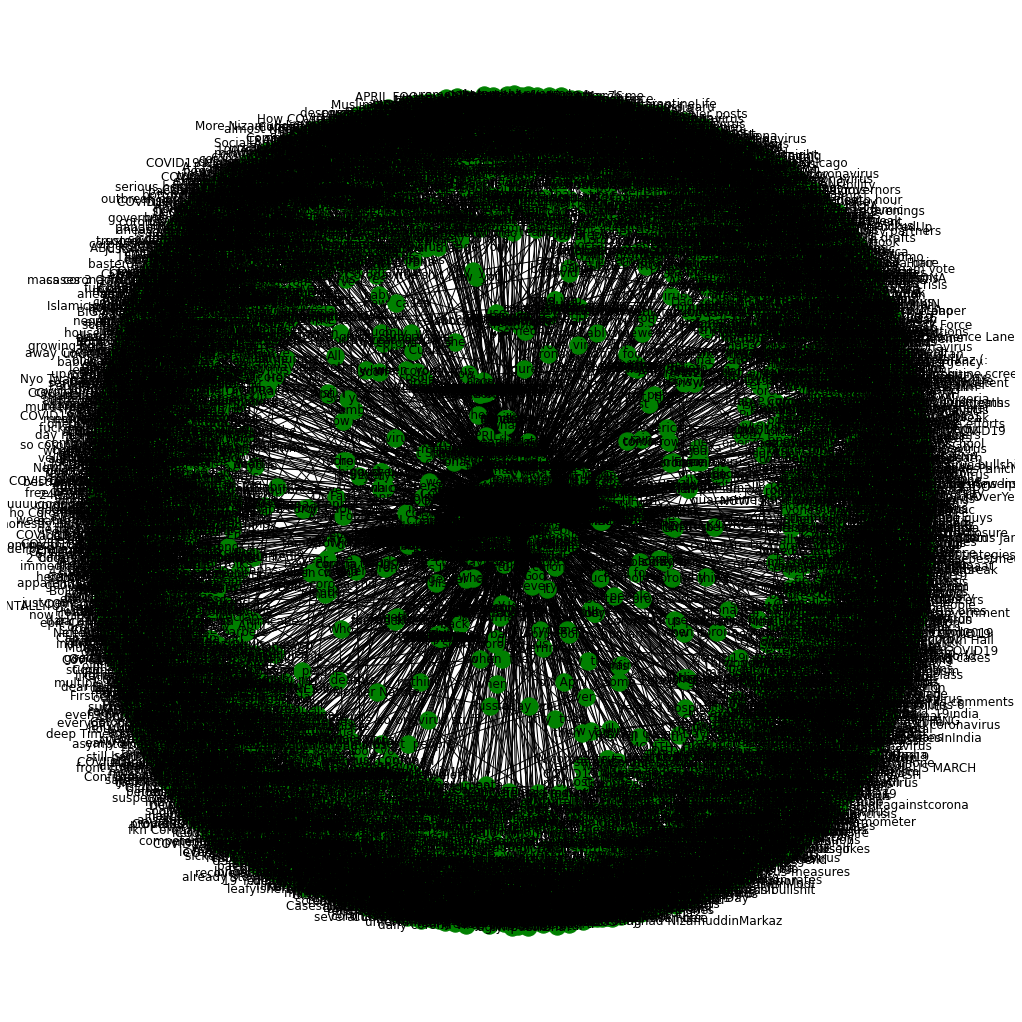

In [57]:
plot.figure(figsize=(14, 14))

posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [77]:
data_kgf['edge']

0             after COVID19
1             BanMediaHouse
2                   waiting
3                   COVID19
4       CoronaVirusOutbreak
               ...         
4995                   know
4996             Be careful
4997            Yellowstone
4998                 banana
4999                COVID19
Name: edge, Length: 5000, dtype: object

### Refining Graph based on certain relations

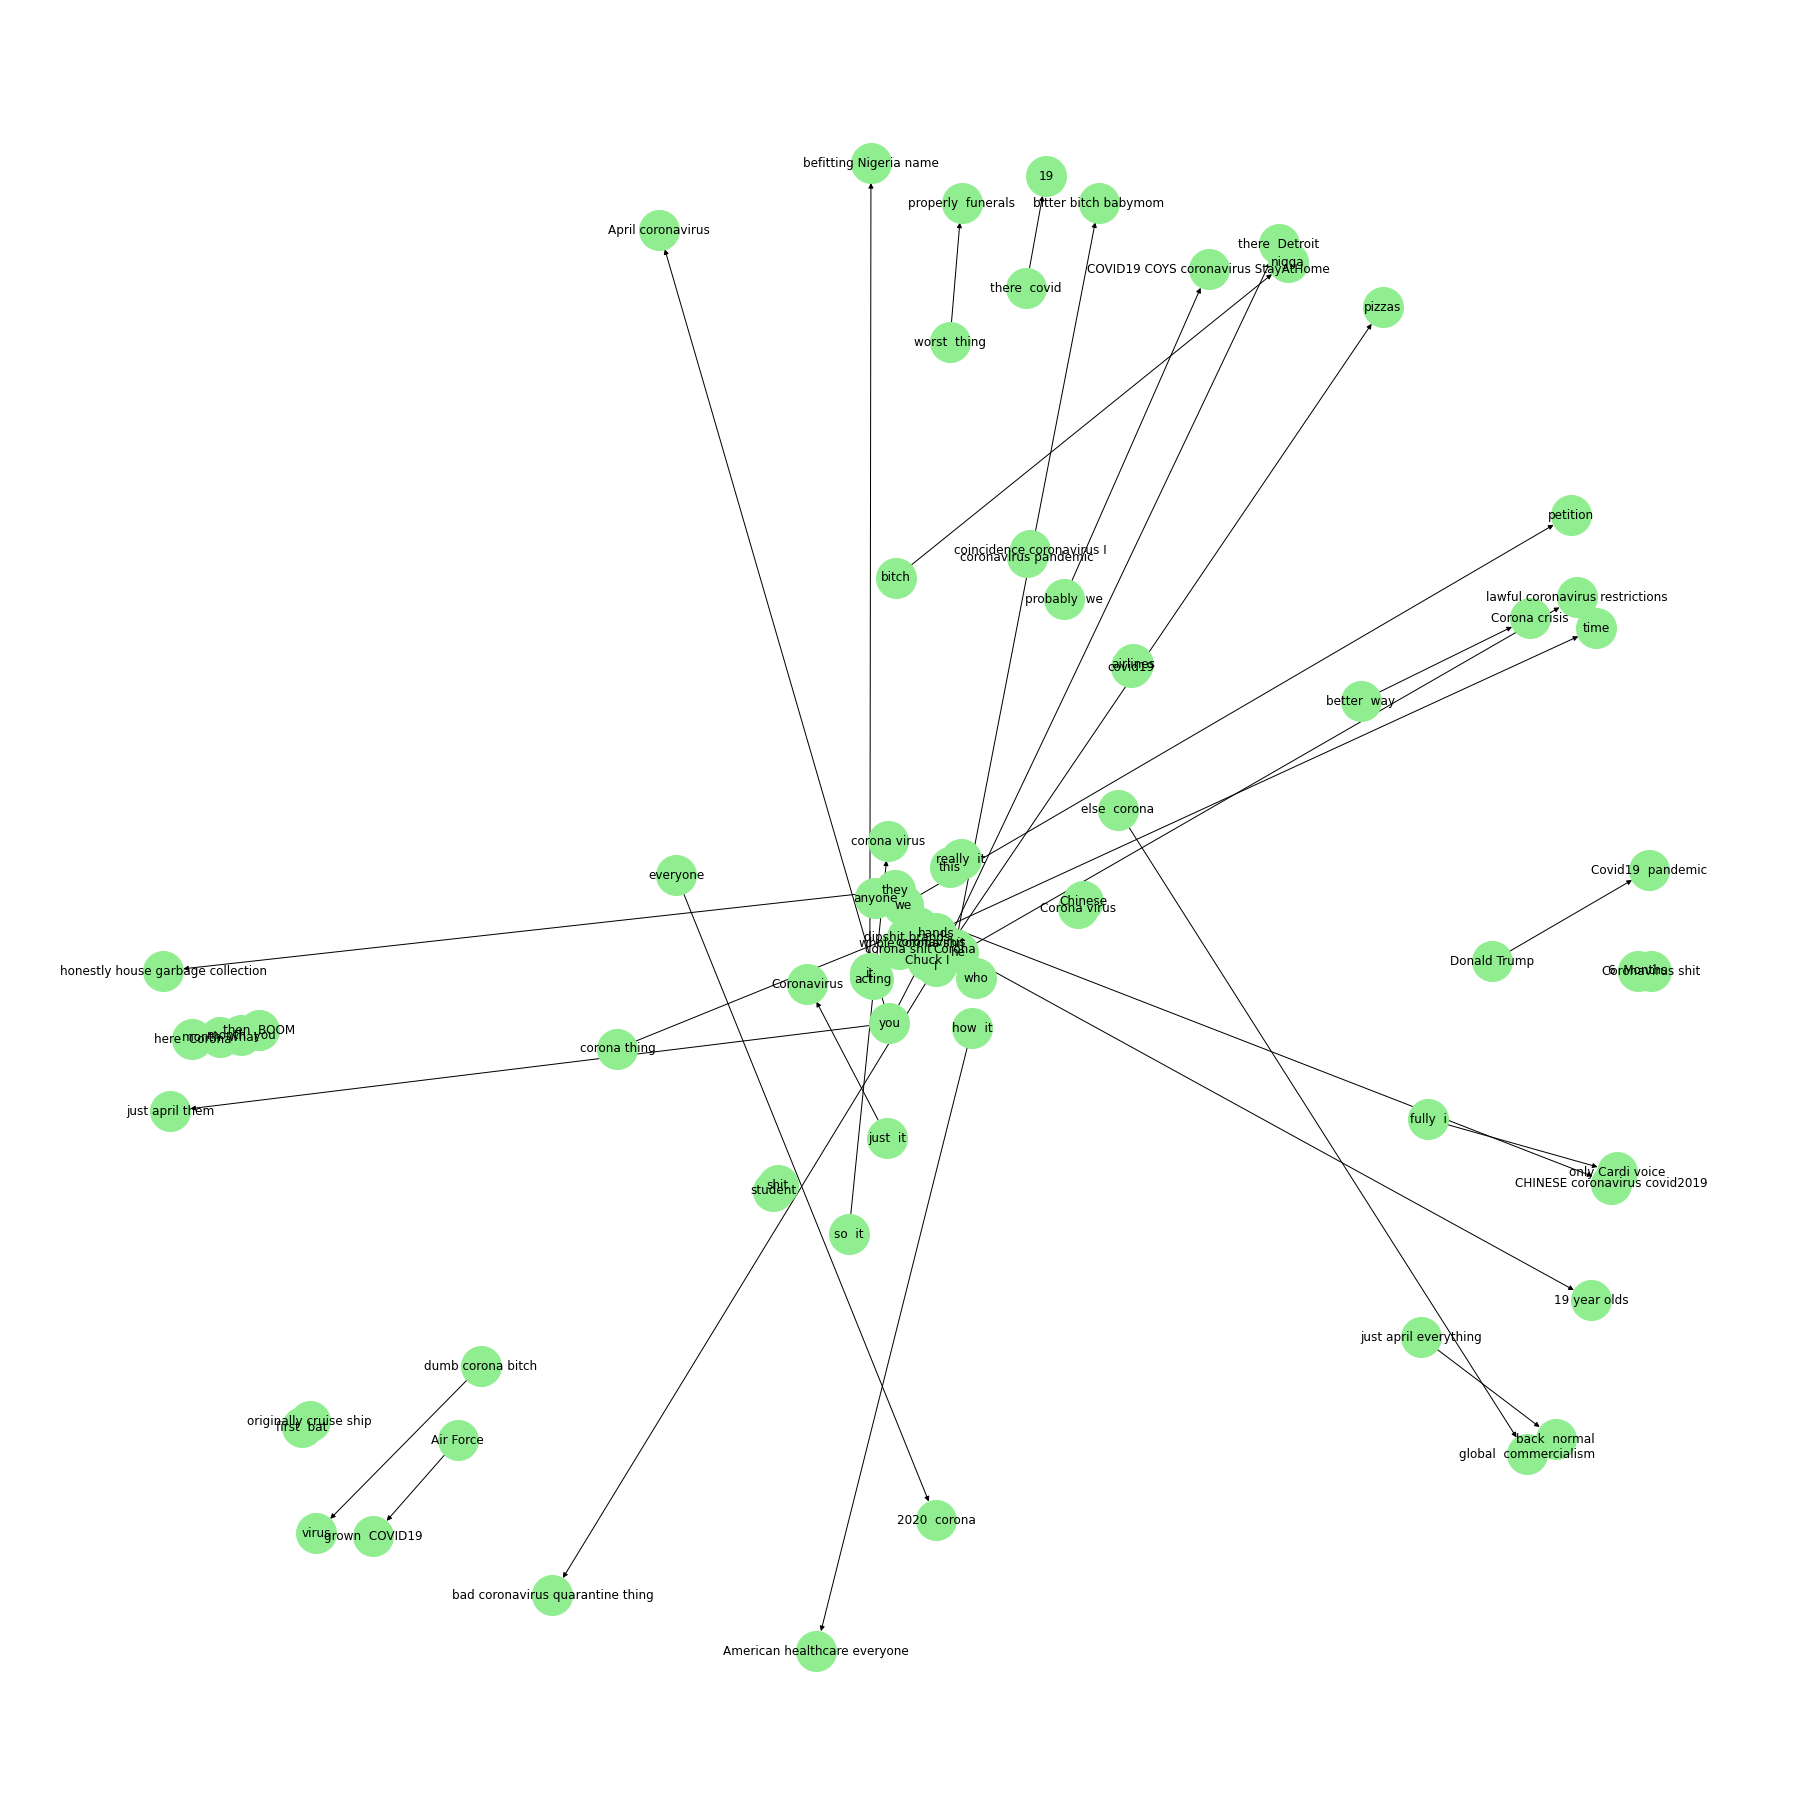

In [90]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="think"], "source", "target", 
                          edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(25,25))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1600, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

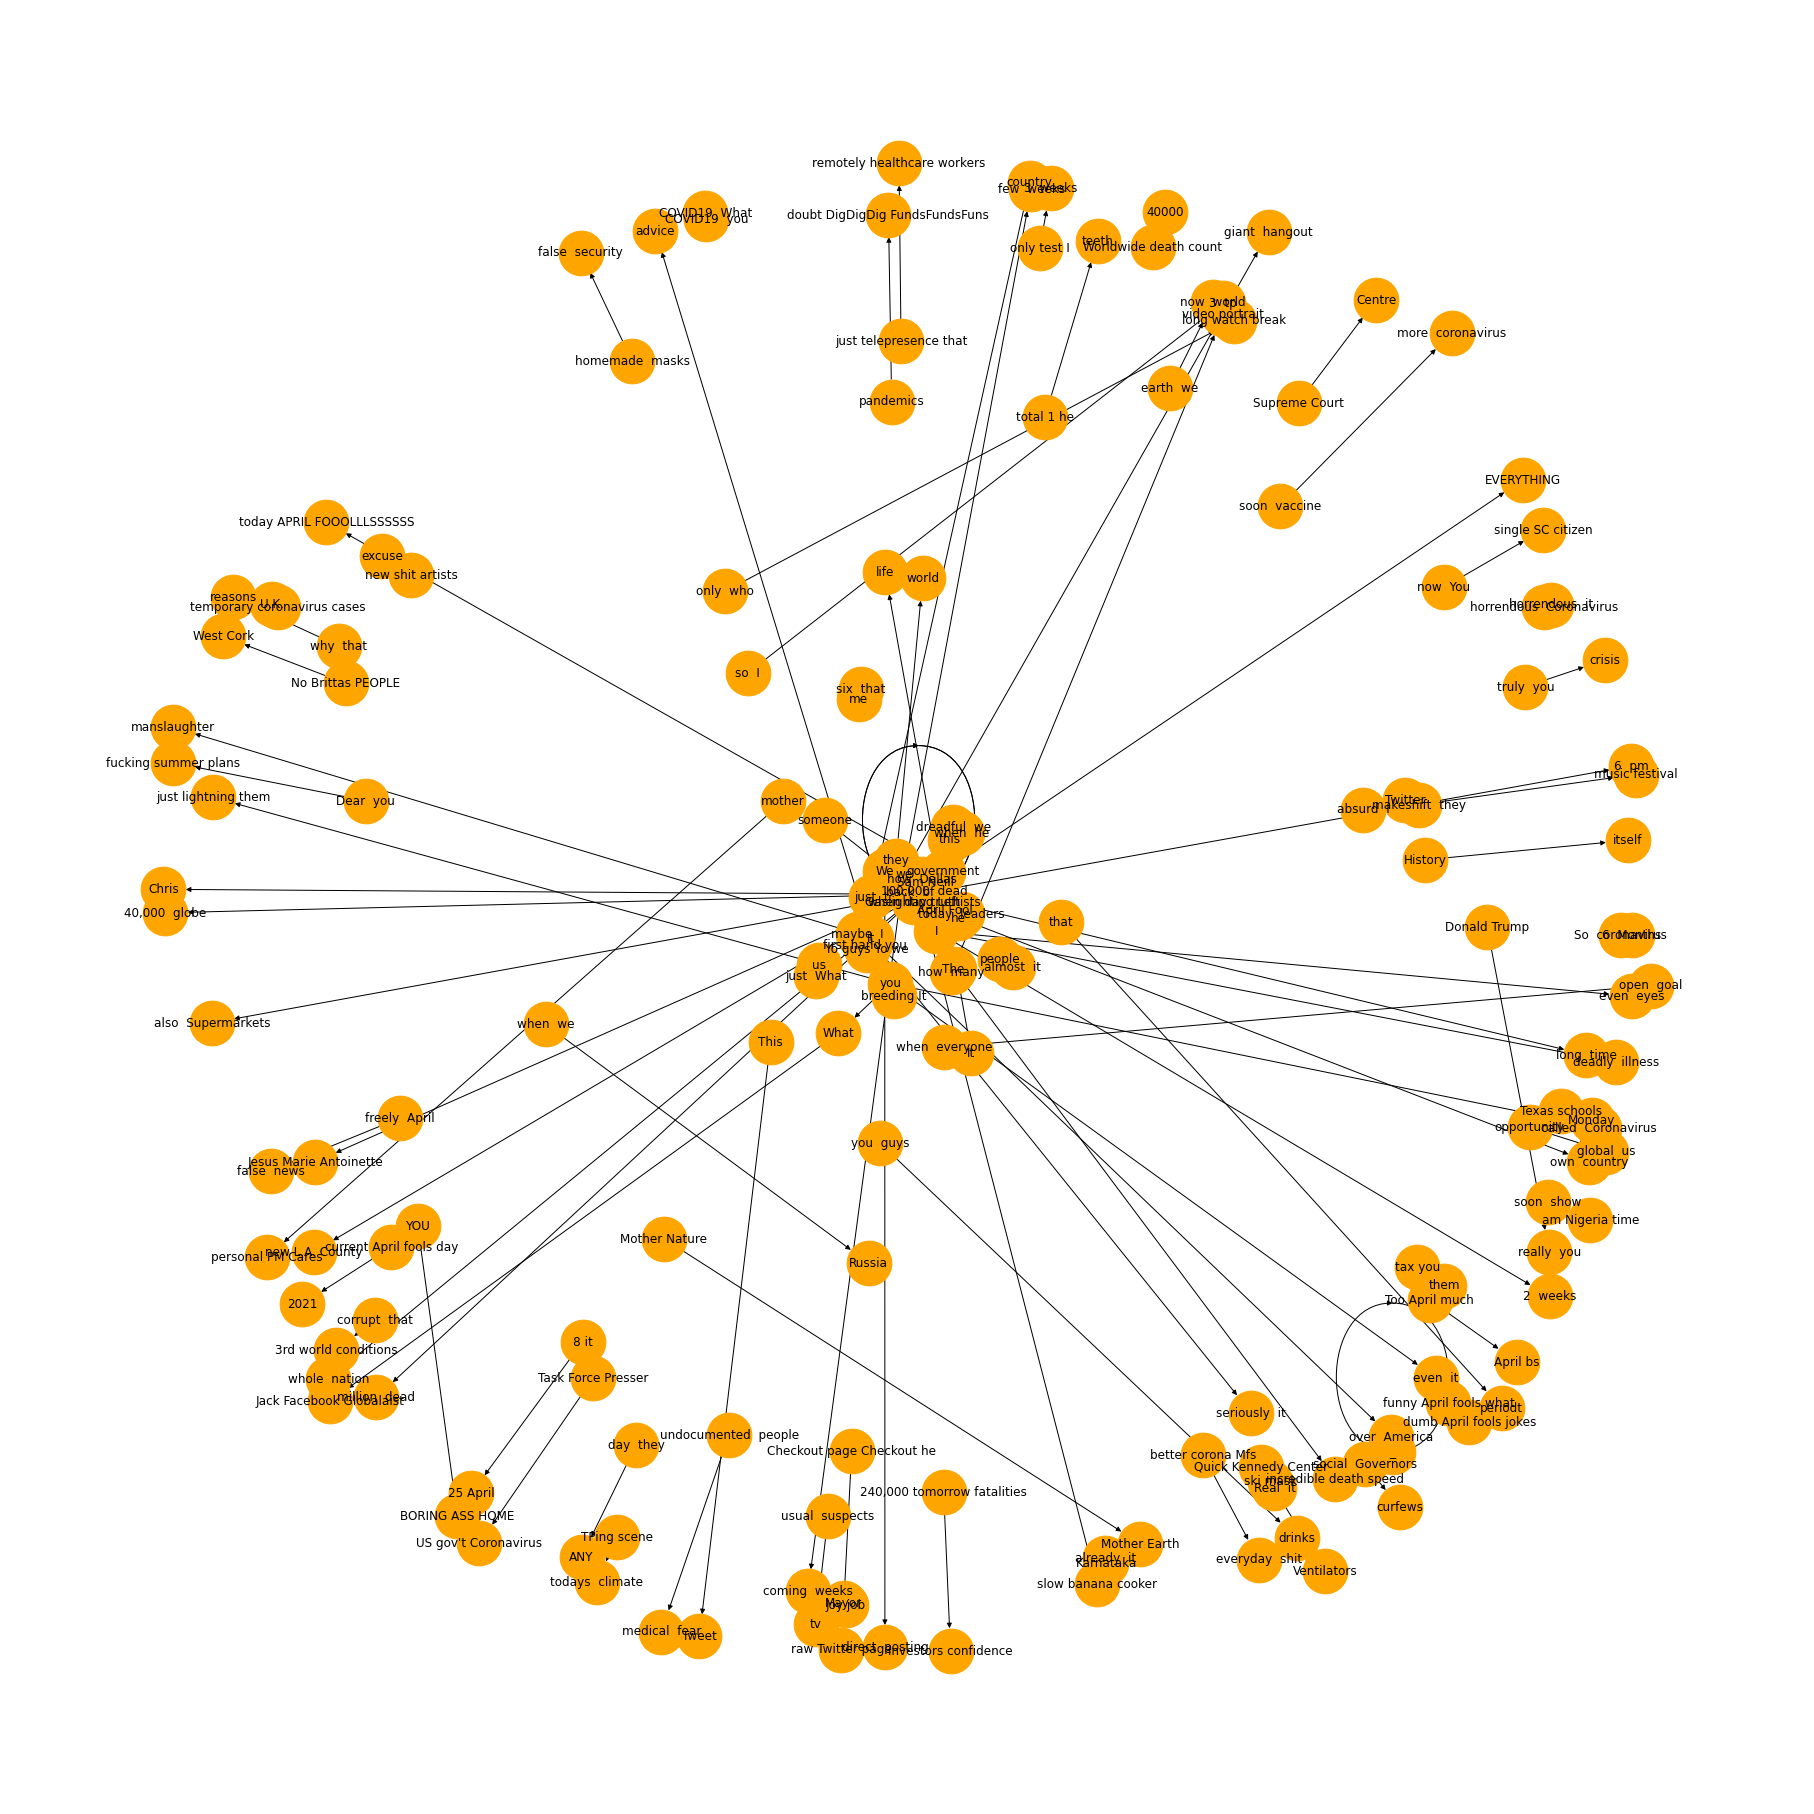

In [91]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="COVID19"], "source", "target", 
                          edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(25,25))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='orange', node_size=2000, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()